# NASNetLarge transfer learning for Single cells

### (Fine tune at 10)


**This project is to distinguish the KPL4-PAR1 cancer cell from KPL4 wild type cell, only by their phase-contrast images.**

The difference in shape between PAR1-overexpressing KPL4 cells and their wilde types is recognizable to some extent by human eyes, in that the PAR1-overexpressing cells typically shows more 'frills' around the cell membrane as a result of active polymerization of actin filaments. However, for some cases, it is hard to tell their types only with the phase-contrast images. In this project, we attempted to distinguish between the phase-contrast images of PAR1-overexpressing KPL4 cells and wild-type KPL4 cells based on deep learning algorithm.
Following figure shows the structure of the overall process.

<img src="../media/fig03_ver00.jpeg" width=700>



The results of transfer learning using *NASNetLarge* showed fairly reliable prediction rate (~95%). Followings are the process of transfer learning conducted for this project.



**Import all the required packages from tensorflow and keras**

In [1]:
# just as shown in https://keras.io/api/preprocessing/image/

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Check the GPU**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

**Data split: train and validation**

The image data for train are separately stored in the folder *train/par1/* and *train/wt/*. Likewise, image data for test (validation) are stored in *val/par1/* and *val/wt/*. The ```image_dataset_from_directory``` commands recognize the class and count the total number if images in the dataset.

In [3]:
# BATCH_SIZE = 32
BATCH_SIZE = 10
# IMG_SIZE = (160, 160)
IMG_SIZE = (331,331) # target image size for NASNet

train_dataset = image_dataset_from_directory('../data_single/data_single_conv_split/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 569 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory('../data_single/data_single_conv_split/val/',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.


**Make sure the classs names are correct**

In [5]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

Show the first nine images and labels from the traning set.

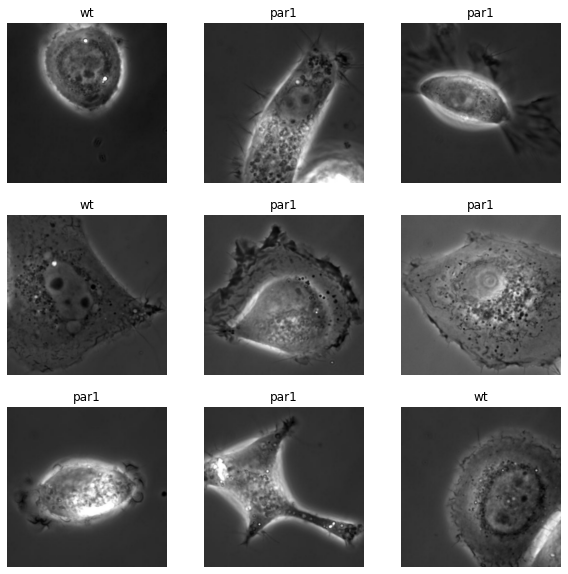

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Divide validation dataset and test dataset**

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set. ```tf.data.experimental.cardinality``` returns the cardinality (natural numbers) of ```dataset```.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide :https://www.tensorflow.org/guide/data_performance

In [15]:
# AUTOTUNE = tf.data.AUTOTUNE # worked at macpro but not in linux
AUTOTUNE = tf.data.experimental.AUTOTUNE # use instead this in linux

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data augmentation**

This helps expose the model to different aspects of the training data and reduce overfitting. We only used rotation here - flipping is not appropriate augmentation due to the characterstics of cell such as polarity (or more)

In [9]:
data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

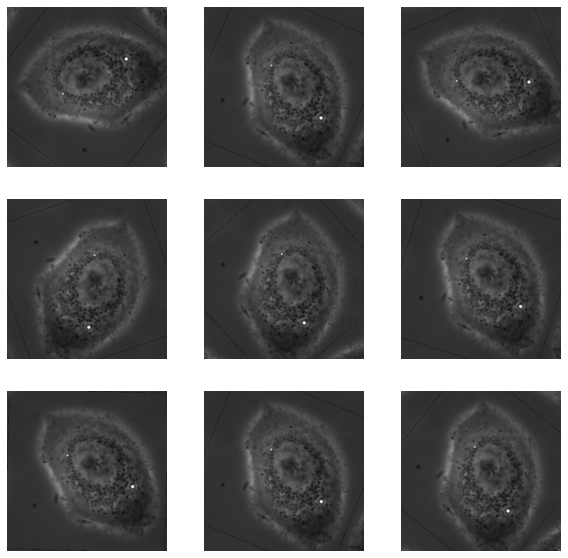

In [10]:
for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Import and set *NasNetLarge* as a base model**

In [11]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input

In [19]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1,1] or [0,1], or use the included preprocess_input function.

#### Create the base model from the pre-trained covnets

You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like ```jackfruit``` and ```syringe```. This base of knowledge will help us classify cats and dogs form our specific dataset. 

First, you nee do pick which layer of MobileNet V2 you will use for feature exreaction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck" layer. The bottleneck layer features retain more generality a compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a neetwork that doesn't include the classification layers at the top, which is ideal for feature extraction. 

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each ```160x160x3``` image into a ```5x5x2048``` block of features. Let's see what it does an exaple batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 11, 11, 4032)


#### Feature extraction


In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier. 

##### Freeze the convolutional base

It is important to freeze the convolutional base before you compile an train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's ```trainable``` flag to False will fressze all of them.

In [24]:
base_model.trainable = False

#### Important note about BatchNoramlization layers

Many models contain ```tf.keras.layers.BatchNormalization``` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as whon later in this tutorial. 

When you set ```layer.trainable=False```, the ```BatchNormalization``` layer will run in inference mode, and will not update its mean and variance statistics. 

When you *unfreeze* a model that contains BatchNormalization layers in order to do fine-tuning, you chould keep the BatchNormalization layers in inference mode by passing ```training=False``` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.  

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

normal_add_3_11 (Add)           (None, 21, 21, 336)  0           normal_left3_11[0][0]            
                                                                 adjust_bn_11[0][0]               
__________________________________________________________________________________________________
normal_add_4_11 (Add)           (None, 21, 21, 336)  0           normal_left4_11[0][0]            
                                                                 normal_right4_11[0][0]           
__________________________________________________________________________________________________
normal_add_5_11 (Add)           (None, 21, 21, 336)  0           separable_conv_2_bn_normal_left5_
                                                                 normal_bn_1_11[0][0]             
__________________________________________________________________________________________________
normal_concat_11 (Concatenate)  (None, 21, 21, 2016) 0           adjust_bn_11[0][0]               
          

#### Add a classification head

To generate predictions from the block of features, average over the spatial ```5x5``` spatial locations, using a ```tf.keras.layers.GlobalAveragePooling``` layer to convert the features to a single 2048-element vector per image.

In [26]:
# the above 5x5 refers to the final output layer shown above model summary
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 4032)


Apply a ```tf.keras.layers.Dense``` layer to convert these features into a single prediction per image. You don;t need an activation function here because this prediction will be treated as a ```logit```, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


Build a model by chaining together the data augementation, rescaling, base_model and feature extractor layers using the keras functional API. As previously mentioned, use training=False as our model contains BatchNormalization layer.

In [28]:
inputs = tf.keras.Input(shape=(331, 331, 3)) # image size
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with ```from_logits=True``` since the model provides a linear output.

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)             

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two ```tf.Variable``` object, the weights and biases.

In [31]:
len(model.trainable_variables)

2

#### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [32]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 1s 107ms/step - loss: 0.7401 - accuracy: 0.5000


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.50


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
57/57 [==============================] - 20s 355ms/step - loss: 0.7063 - accuracy: 0.5220 - val_loss: 0.6618 - val_accuracy: 0.6000
Epoch 2/10
57/57 [==============================] - 8s 138ms/step - loss: 0.6609 - accuracy: 0.5659 - val_loss: 0.6196 - val_accuracy: 0.6500
Epoch 3/10
57/57 [==============================] - 8s 140ms/step - loss: 0.6381 - accuracy: 0.5905 - val_loss: 0.5926 - val_accuracy: 0.7125
Epoch 4/10
57/57 [==============================] - 8s 141ms/step - loss: 0.6146 - accuracy: 0.5993 - val_loss: 0.5632 - val_accuracy: 0.7125
Epoch 5/10
57/57 [==============================] - 8s 141ms/step - loss: 0.5838 - accuracy: 0.6397 - val_loss: 0.5291 - val_accuracy: 0.7750
Epoch 6/10
57/57 [==============================] - 8s 141ms/step - loss: 0.5665 - accuracy: 0.6678 - val_loss: 0.5241 - val_accuracy: 0.7625
Epoch 7/10
57/57 [==============================] - 8s 143ms/step - loss: 0.5491 - accuracy: 0.6749 - val_loss: 0.4933 - val_accuracy: 0.7625
Epoch

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

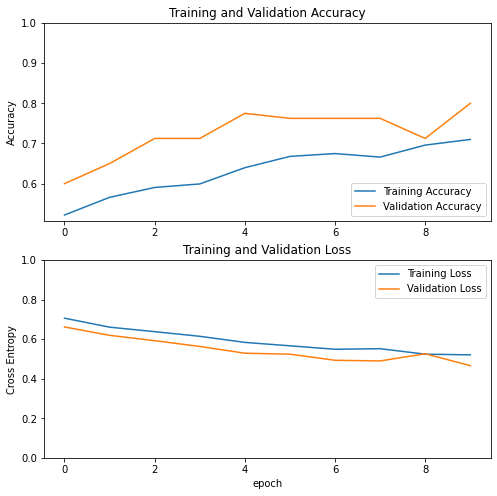

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Note: If you are wondering why the validation metrics are clearly better than 
# the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and 
# tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that hase trained slightly longer.

### Fine tuning

In the feature extraction experiment, you were only trianing a few layers on top of a MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the clssifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

*This should be only attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the geatures are inscreasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrtie the generic learning.

#### Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  1039


#### Compile the model

As you are training a **much larger model** and want to readapt the pre-trained weights, **it is important to use a lower learning rateat this stage**. Otherwise, your model could overfit very quickly. 

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)             

In [41]:
len(model.trainable_variables)

1012

In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
57/57 [==============================] - 66s 1s/step - loss: 0.3684 - accuracy: 0.8295 - val_loss: 0.2396 - val_accuracy: 0.8750
Epoch 11/20
57/57 [==============================] - 40s 700ms/step - loss: 0.2022 - accuracy: 0.9227 - val_loss: 0.1706 - val_accuracy: 0.9375
Epoch 12/20
57/57 [==============================] - 40s 702ms/step - loss: 0.1423 - accuracy: 0.9332 - val_loss: 0.1105 - val_accuracy: 0.9625
Epoch 13/20
57/57 [==============================] - 40s 706ms/step - loss: 0.0893 - accuracy: 0.9666 - val_loss: 0.1330 - val_accuracy: 0.9375
Epoch 14/20
57/57 [==============================] - 40s 707ms/step - loss: 0.0805 - accuracy: 0.9649 - val_loss: 0.1264 - val_accuracy: 0.9375
Epoch 15/20
57/57 [==============================] - 40s 707ms/step - loss: 0.0433 - accuracy: 0.9807 - val_loss: 0.2011 - val_accuracy: 0.9500
Epoch 16/20
57/57 [==============================] - 40s 710ms/step - loss: 0.0465 - accuracy: 0.9807 - val_loss: 0.1228 - val_accuracy: 0.

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting. 

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation st.

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

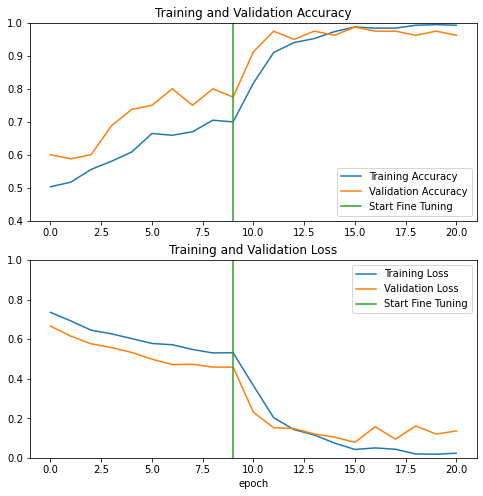

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluation and prediction

Finally, you can verify the performance of the model on new data using test set.

In [58]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 72ms/step - loss: 0.0036 - accuracy: 1.0000
Test accuracy : 1.0


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 1 0 0 0 1 1 0]
Labels:
 [0 1 0 1 0 0 0 1 1 0]


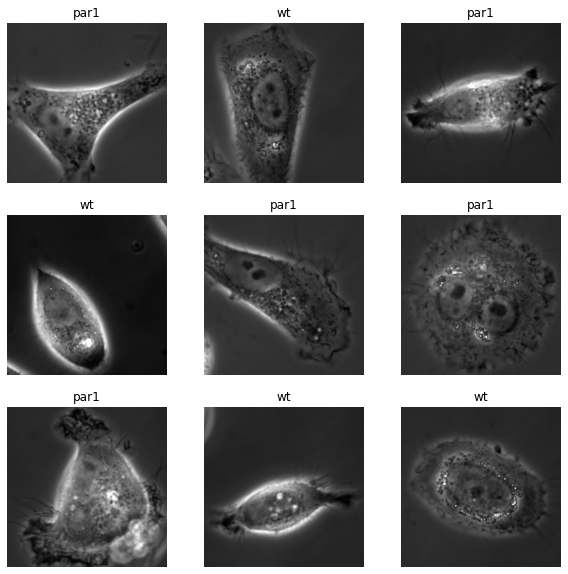

In [59]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [60]:
import pickle
with open("./linux_initial_history_saved/nasnetlarge_single_cell",'wb') as file_pi:
    pickle.dump(history_fine.history, file_pi)

In [61]:
test_load = pickle.load(open("./linux_initial_history_saved/nasnetlarge_single_cell",'rb'))
test_load['loss']

[0.3652065396308899,
 0.2026711404323578,
 0.1427604705095291,
 0.1152363196015358,
 0.07440288364887238,
 0.04223112761974335,
 0.04997599124908447,
 0.0432465597987175,
 0.019247330725193024,
 0.018061179667711258,
 0.023171253502368927]